In [1]:
import yfinance as yf
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

            1. open  2. high    3. low  4. close   5. volume
date                                                        
2025-05-01  209.080   214.56  208.9000    213.32  57365675.0
2025-04-30  209.300   213.58  206.6705    212.50  52286454.0
2025-04-29  208.693   212.24  208.3700    211.21  36827633.0
2025-04-28  210.000   211.50  207.4600    210.14  38743074.0
2025-04-25  206.365   209.75  206.2000    209.28  38222258.0


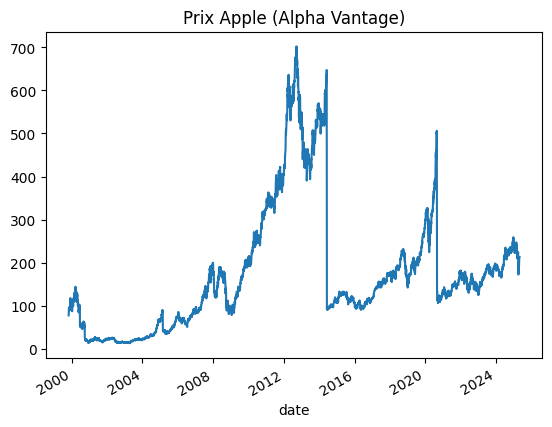

In [2]:
from alpha_vantage.timeseries import TimeSeries

#clé API gratuite sur https://www.alphavantage.co/
api_key = 'E26EF809WUN3SROE'

ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol='AAPL', outputsize='full')

print(data.head())
data['4. close'].plot(title="Prix Apple (Alpha Vantage)")
plt.show()

Les données ont été sauvegardées dans le fichier 'AAPL_alpha_vantage.csv'.


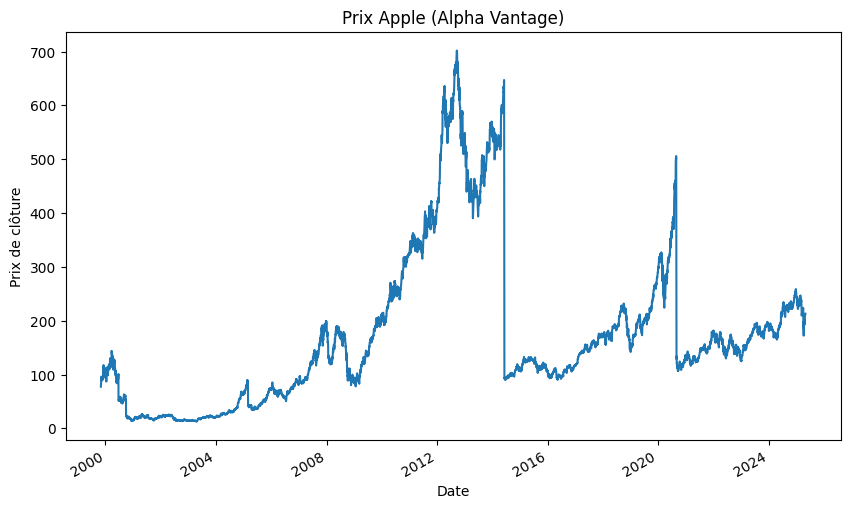

In [3]:
data.to_csv('AAPL_alpha_vantage.csv')
print("Données sauvegardées dans le fichier 'AAPL_alpha_vantage.csv'.")

data['4. close'].plot(title="Prix Apple (Alpha Vantage)", figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.show()

In [4]:
data.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-05-01,209.080,214.56,208.9000,213.32,57365675.0
2025-04-30,209.300,213.58,206.6705,212.50,52286454.0
2025-04-29,208.693,212.24,208.3700,211.21,36827633.0
2025-04-28,210.000,211.50,207.4600,210.14,38743074.0
2025-04-25,206.365,209.75,206.2000,209.28,38222258.0


In [11]:
data = data.reset_index()

In [12]:
data.head(2)

,date,1. open,2. high,3. low,4. close,5. volume
0,2025-05-01,209.08,214.56,208.9000,213.32,57365675.0
1,2025-04-30,209.30,213.58,206.6705,212.50,52286454.0


In [24]:
import altair as alt

In [21]:
data = data[(data['date'] >= '2020-01-01') & (data['date'] <= '2025-12-31')]

data.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2025-05-01,209.080,214.56,208.9000,213.32,57365675.0
1,2025-04-30,209.300,213.58,206.6705,212.50,52286454.0
2,2025-04-29,208.693,212.24,208.3700,211.21,36827633.0
3,2025-04-28,210.000,211.50,207.4600,210.14,38743074.0
4,2025-04-25,206.365,209.75,206.2000,209.28,38222258.0


In [33]:
data.columns

Index(['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'MA10'], dtype='object')

In [ ]:
data.to_csv('filtered_AAPL_alpha_vantage.csv', index=False)

In [22]:
data['date'] = pd.to_datetime(data['date'])
data.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
}, inplace=True)

In [23]:
data.loc[:, 'MA10'] = data['Close'].rolling(window=10).mean()


In [ ]:
chart = alt.Chart(data).mark_line().encode(
    x='date:T',  
    y='Close:Q', 
    color=alt.value('steelblue')
).properties(
    width=800,
    height=400,
    title='Closing Price'
)

In [32]:
ma_line = alt.Chart(data).mark_line().encode(
    x='date:T',
    y='MA10:Q',
    color=alt.value('orange')
)

In [28]:
final_chart = (chart + ma_line).properties(
    title='Stock Price with 10-Day Moving Average (2020-2025)'
).interactive().configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
)

In [135]:
final_chart

alt.LayerChart(...)

# Data Cleaning & Preprocessing 

In [31]:
data.isna().sum()

date      0
Open      0
High      0
Low       0
Close     0
Volume    0
MA10      9
dtype: int64

In [136]:
data.columns

Index(['date', '1. open', '2. high', '3. low', '4. close', '5. volume'], dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

for i in range(1, 6):
    data[f'Close_t-{i}'] = data['4. close'].shift(i)

data['Target'] = data['4. close'].shift(-1)

data = data.dropna()

X = data[['Close_t-1', 'Close_t-2', 'Close_t-3', 'Close_t-4', 'Close_t-5', '5. volume']]
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4485, 6)
X_test shape: (1923, 6)
y_train shape: (4485,)
y_test shape: (1923,)


Test Random pour utilisé le maximum de ML 

In [154]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

models = {
    'Régression Linéaire': LinearRegression(),
    'Régression Polynomiale (deg 3)': make_pipeline(PolynomialFeatures(2), LinearRegression()),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    results[name] = {
        'Train MSE': mean_squared_error(y_train, train_pred),
        'Test MSE': mean_squared_error(y_test, test_pred)
    }

pd.DataFrame(results).T

,Train MSE,Test MSE
Régression Linéaire,244.6641,10.7200
Régression Polynomiale (deg 3),609.6394,318.7202


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

tscv = TimeSeriesSplit(n_splits=5)

In [155]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

ridge_params = {'alpha': [0.01, 0.1, 1, 10]}
ridge = GridSearchCV(Ridge(), ridge_params, cv=tscv, scoring='neg_mean_squared_error')

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5]
}
rf = GridSearchCV(RandomForestRegressor(), rf_params, cv=tscv, scoring='neg_mean_squared_error')

xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse'
)


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(50, 50),
    activation='relu',
    solver='adam',
    early_stopping=True,
    validation_fraction=0.2
)

from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

estimators = [
    ('ridge', Ridge(alpha=1.0)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=5))
]

stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor()
)

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from time import time

models = {
    'Ridge': {
        'model': ridge,
        'params': {'alpha': 1.0}  
    },
    'Random Forest': {
        'model': rf.best_estimator_ if hasattr(rf, 'best_estimator_') else rf,
        'feature_importance': True
    },
    'MLP': {
        'model': mlp,
        'requires_scaling': True
    },
    'Stacking': {
        'model': stacking,
        'meta_model': True
    }
}

results = {}
feature_importances = {}

for name, config in models.items():
    print(f"\nTraining {name}...")
    start_time = time()
    model = config['model']
    
    model.fit(X_train_scaled, y_train)
    
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'Train MSE': mean_squared_error(y_train, y_pred_train),
        'Test MSE': mean_squared_error(y_test, y_pred_test),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Overfitting Score': (mean_squared_error(y_train, y_pred_train) - 
                            mean_squared_error(y_test, y_pred_test)),
        'Training Time (s)': time() - start_time
    }
    
    if config.get('feature_importance', False):
        if hasattr(model, 'feature_importances_'):
            feature_importances[name] = model.feature_importances_
        elif hasattr(model, 'coef_'):
            feature_importances[name] = np.abs(model.coef_)

results_df = pd.DataFrame(results).T.sort_values('Test RMSE')

pd.set_option('display.float_format', '{:.4f}'.format)
print("\n" + "="*80)
print("Performance Comparative des Modèles (Trié par Test RMSE)")
print("="*80)
print(results_df[['Test RMSE', 'Test R²', 'Test MAE', 'Overfitting Score', 'Training Time (s)']])

if feature_importances:
    print("\n" + "="*80)
    print("Importance des Features par Modèle")
    print("="*80)
    for model_name, importance in feature_importances.items():
        print(f"\n{model_name}:")
        feat_imp = pd.Series(importance, index=X.columns)
        print(feat_imp.sort_values(ascending=False).head(10))


Training Ridge...

Training Random Forest...

Training MLP...


C:\Users\gabyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Training Stacking...

Performance Comparative des Modèles (Trié par Test RMSE)
               Test RMSE  Test R²  Test MAE  Overfitting Score  \
Ridge            27.3320   0.9379    6.8584          -726.4078   
MLP              47.4447   0.8128   26.8723         -2127.6020   
Stacking         71.6048   0.5736   40.5299         -5108.5270   
Random Forest    72.2878   0.5655   45.7236         -5199.4101   

               Training Time (s)  
Ridge                     0.0604  
MLP                       1.3145  
Stacking                  2.1934  
Random Forest             0.2518  

Importance des Features par Modèle

Random Forest:
Close_t-1   0.8324
Close_t-2   0.0856
Close_t-3   0.0379
Close_t-4   0.0296
Close_t-5   0.0144
Volume      0.0000
dtype: float64


ARIMA

C:\Users\gabyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\gabyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\gabyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, 

Test RMSE: 77.7644


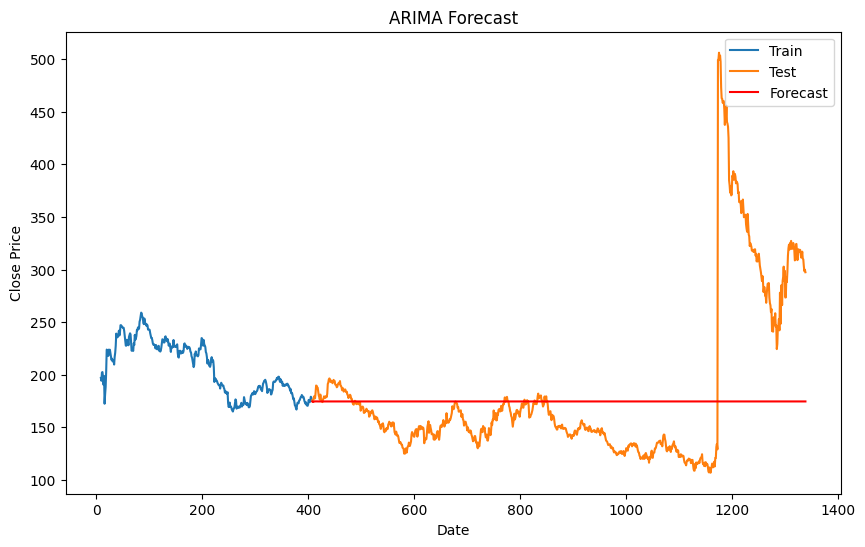

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

series = data['Close']

train_size = int(len(series) * 0.3)
train, test = series[:train_size], series[train_size:]

model = ARIMA(train, order=(5, 1, 0))  # (p, d, q) 
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [158]:
data.columns

Index(['date', '1. open', '2. high', '3. low', '4. close', '5. volume',
       'Close_t-1', 'Close_t-2', 'Close_t-3', 'Close_t-4', 'Close_t-5',
       'Target'],
      dtype='object')

In [58]:
from alpha_vantage.timeseries import TimeSeries


In [72]:
api_key = 'E26EF809WUN3SROE'

ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol='AAPL', outputsize='full')

In [75]:
print("Aperçu des données AAPL:")
print(data.head(10))

Aperçu des données AAPL:
            1. open  2. high   3. low  4. close     5. volume
date                                                         
2025-05-01 209.0800 214.5600 208.9000  213.3200 57365675.0000
2025-04-30 209.3000 213.5800 206.6705  212.5000 52286454.0000
2025-04-29 208.6930 212.2400 208.3700  211.2100 36827633.0000
2025-04-28 210.0000 211.5000 207.4600  210.1400 38743074.0000
2025-04-25 206.3650 209.7500 206.2000  209.2800 38222258.0000
2025-04-24 204.8900 208.8299 202.9400  208.3700 47310989.0000
2025-04-23 206.0000 208.0000 202.7990  204.6000 52929165.0000
2025-04-22 196.1200 201.5900 195.9700  199.7400 52976371.0000
2025-04-21 193.2650 193.8000 189.8112  193.1600 46742537.0000
2025-04-17 197.2000 198.8335 194.4200  196.9800 52164675.0000


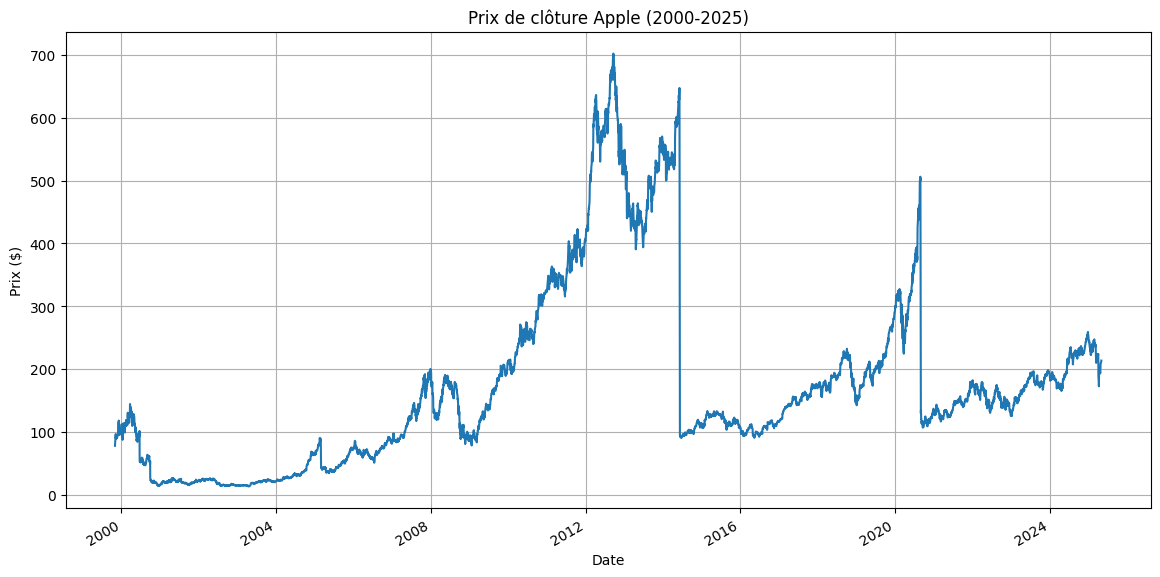

In [74]:
plt.figure(figsize=(14, 7))
data['4. close'].plot(title="Prix de clôture Apple (2000-2025)")
plt.xlabel('Date')
plt.ylabel('Prix ($)')
plt.grid(True)
plt.show()

In [81]:
data.head(3)

,date,1. open,2. high,3. low,4. close,5. volume
0,2025-05-01,209.0800,214.5600,208.9000,213.3200,57365675.0000
1,2025-04-30,209.3000,213.5800,206.6705,212.5000,52286454.0000
2,2025-04-29,208.6930,212.2400,208.3700,211.2100,36827633.0000


In [78]:
data.reset_index(inplace=True)

In [97]:
filtered_data = data[(data['date'] >= '2020-01-01') & (data['date'] <= '2025-12-31')]

In [102]:
# colonne pour les rendements quotidiens (variation en %)
filtered_data['return'] = filtered_data['4. close'].pct_change() * 100

In [98]:
filtered_data.head(2)

,date,1. open,2. high,3. low,4. close,5. volume
0,2025-05-01,209.0800,214.5600,208.9000,213.3200,57365675.0000
1,2025-04-30,209.3000,213.5800,206.6705,212.5000,52286454.0000


In [86]:
filtered_data.fillna(0, inplace=True)

In [99]:
filtered_data.set_index('date', inplace=True)

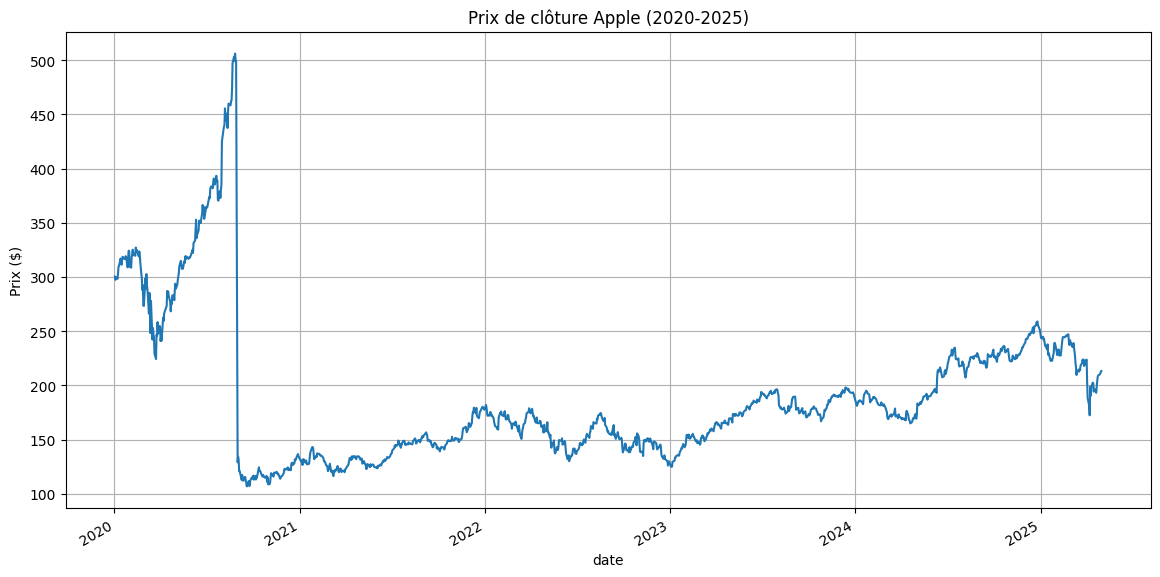

In [100]:
plt.figure(figsize=(14, 7))
filtered_data['4. close'].plot(title="Prix de clôture Apple (2020-2025)")
plt.xlabel('date')
plt.ylabel('Prix ($)')
plt.grid(True)
plt.show()

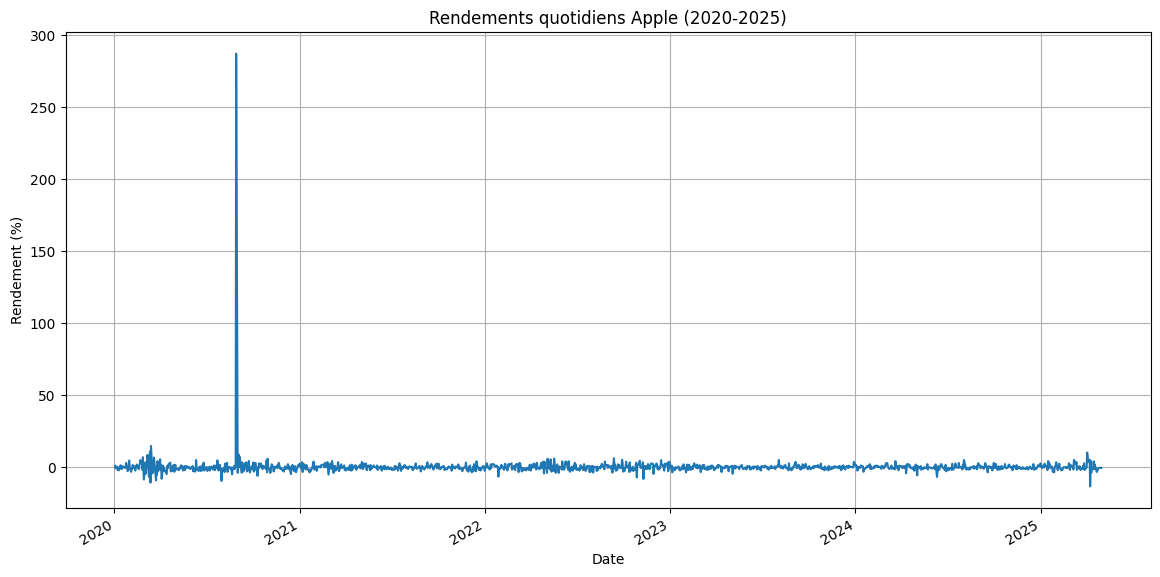

In [103]:
plt.figure(figsize=(14, 7))
filtered_data['return'].plot(title="Rendements quotidiens Apple (2020-2025)")
plt.xlabel('Date')
plt.ylabel('Rendement (%)')
plt.grid(True)
plt.show()

# Test/Train

In [104]:
test_size = 0.2
split_idx = int(len(filtered_data) * (1 - test_size))

train_data = filtered_data.iloc[:split_idx]
test_data = filtered_data.iloc[split_idx:]


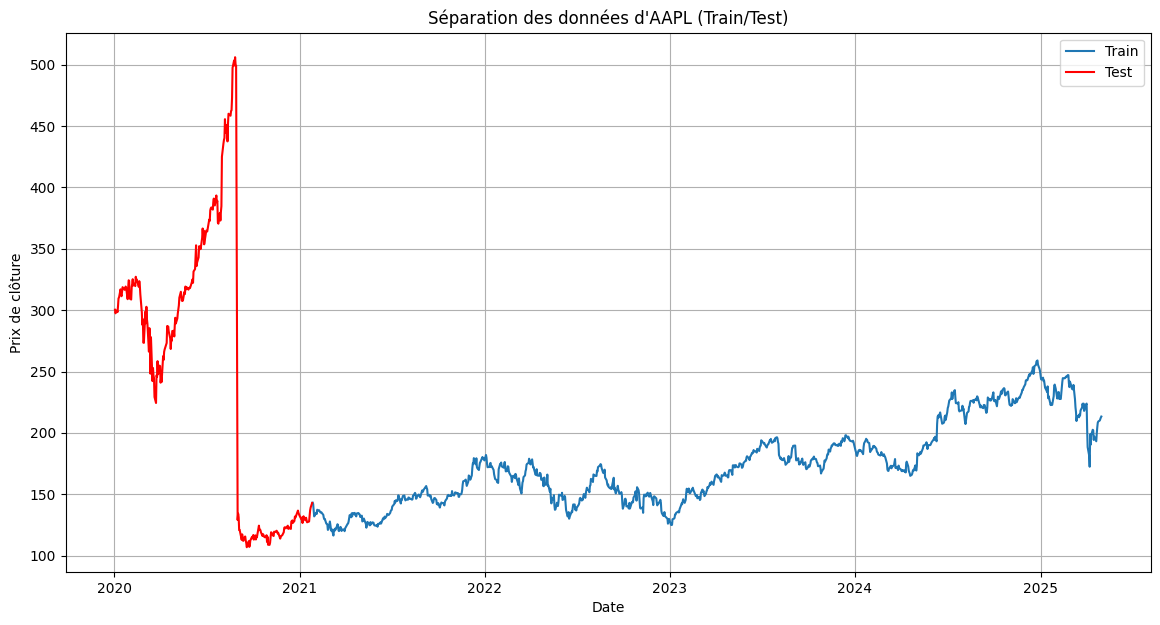

In [105]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['4. close'], label='Train')
plt.plot(test_data.index, test_data['4. close'], label='Test', color='red')
plt.title('Séparation des données d\'AAPL (Train/Test)')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.legend()
plt.grid(True)
plt.show()

In [108]:
# Pour les modèles ARIMA, SARIMA

y_train = train_data['4. close'].values
y_test = test_data['4. close'].values

# Pour Prophet
train_dates = train_data.index
test_dates = test_data.index

In [ ]:
# df format Prophet
train_df_prophet = pd.DataFrame({'ds': train_dates, 'y': train_data['4. close'].values})
test_df_prophet = pd.DataFrame({'ds': test_dates, 'y': test_data['4. close'].values})

In [110]:
print("\nTaille des données:")
print(f"Ensemble d'entraînement: {len(train_data)} observations")
print(f"Ensemble de test: {len(test_data)} observations")


Taille des données:
Ensemble d'entraînement: 1072 observations
Ensemble de test: 268 observations


# Modèles 

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

ARIMA

In [121]:
order = (2, 1, 1)
model_arima = ARIMA(y_train, order=order)
model_fit_arima = model_arima.fit()
print(model_fit_arima.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1072
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2725.761
Date:                Fri, 02 May 2025   AIC                           5459.523
Time:                        16:44:10   BIC                           5479.428
Sample:                             0   HQIC                          5467.063
                               - 1072                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5035      0.443     -1.137      0.256      -1.372       0.365
ar.L2          0.0336      0.022      1.551      0.121      -0.009       0.076
ma.L1          0.5193      0.450      1.155      0.2

In [122]:
train_pred_arima = model_fit_arima.predict(start=0, end=len(y_train)-1)
test_pred_arima = model_fit_arima.forecast(steps=len(y_test))

In [123]:
train_mse_arima = mean_squared_error(y_train, train_pred_arima)
test_mse_arima = mean_squared_error(y_test, test_pred_arima)
train_mae_arima = mean_absolute_error(y_train, train_pred_arima)
test_mae_arima = mean_absolute_error(y_test, test_pred_arima)

In [124]:
print(f"ARIMA - Train MSE: {train_mse_arima:.4f}, Test MSE: {test_mse_arima:.4f}")
print(f"ARIMA - Train MAE: {train_mae_arima:.4f}, Test MAE: {test_mae_arima:.4f}")

ARIMA - Train MSE: 51.9493, Test MSE: 25028.0226
ARIMA - Train MAE: 2.3843, Test MAE: 126.2728


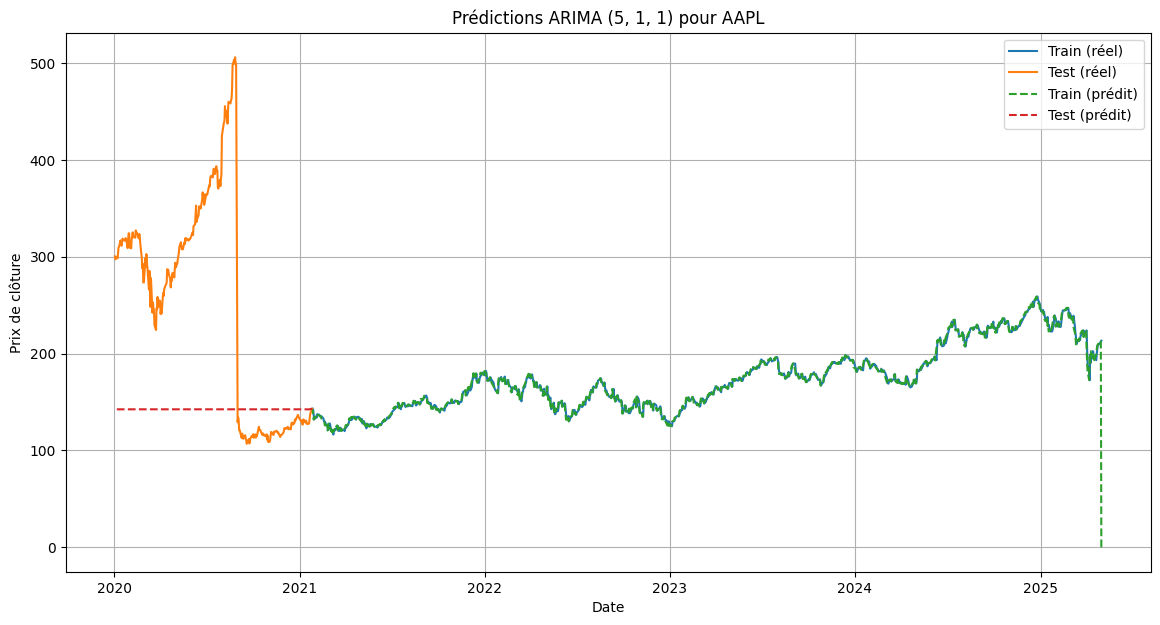

In [116]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, y_train, label='Train (réel)')
plt.plot(test_data.index, y_test, label='Test (réel)')
plt.plot(train_data.index, train_pred_arima, label='Train (prédit)', linestyle='--')
plt.plot(test_data.index, test_pred_arima, label='Test (prédit)', linestyle='--')
plt.title(f'Prédictions ARIMA {order} pour AAPL')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.legend()
plt.grid(True)
plt.show()

ARIMA (en mode auto)